In [6]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import xml.etree.ElementTree as ET

ImportError: cannot import name 'ExceptionWrapper' from 'torch._utils' (/usr/local/lib/python3.7/site-packages/torch/_utils.py)

In [3]:
def get_labels(base,name):
    labels = []
    tree = ET.parse(base+name)
    root = tree.getroot()
    for child in root:
        if child.tag == 'object':
            for obj in child:
                if obj.tag == 'name':
                    labels.append(obj.text)

    return list(set(labels))

In [4]:
images_path = "../VOCdevkit/VOC2007/JPEGImages/"
annotations_path= "../VOCdevkit/VOC2007/Annotations/"
image_filenames = os.listdir(images_path)
train_images = []
for filename in image_filenames:
    my_image = Image.open(images_path + filename)
    train_images.append(my_image.copy())
    my_image.close()
    my_labels = get_labels(annotations_path,filename.split(".")[0]+'.xml')
    
plt.imshow(np.asarray(train_images[0]))

NameError: name 'os' is not defined

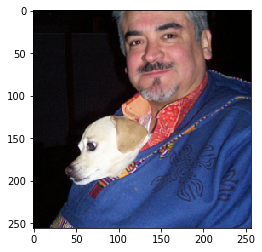

In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256)
])
train_images = [transform(i) for i in train_images]
plt.imshow(np.asarray(train_images[0]))